In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 28 23:52:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    34W / 250W |  15993MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os 
import pandas as pd 
import numpy as np
import sqlite3

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 66.1 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 73.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForQuestionAnswering
from sklearn.model_selection import train_test_split


df = pd.read_csv('/content/drive/MyDrive/SEW.NLP/qasper_df.csv', index_col=0).drop_duplicates().reset_index(drop=True)
intro_papers_df = pd.read_csv('/content/drive/MyDrive/SEW.NLP/intro_papers_df.csv', index_col=0)

df["introPaper"], intro_papers_df["introPaper"] = False, True
df = pd.concat([df, intro_papers_df], axis=0).reset_index(drop=True)

# only keep questions related to the data
search_for = ["data", "feature", "variable", "result", "preprocessing", "labels", "baseline", "metric"]
df_filtered = df.loc[df["question"].str.contains("|".join(search_for))]
# df_filtered["start-end"] = df_filtered.apply(lambda x: (x["start_index"], x["end_index"]), axis=1)
# df_filtered = df_filtered.groupby(["question", "context"])["start-end"].apply(list).reset_index()

In [ ]:
count_answers = df_filtered.groupby(["question", "context"])["answer"].count().reset_index()
context_mult_answers = count_answers[count_answers["answer"] > 1]["context"]
df_filtered = df_filtered[(df_filtered["start_index"] != -1) | (~df_filtered["context"].isin(context_mult_answers))]

In [ ]:
df_filtered["min_start_idx"] = df_filtered.groupby(["question", "context"])["start_index"].transform("min")
df_filtered["max_end_idx"] = df_filtered.groupby(["question", "context"])["end_index"].transform("max")

In [ ]:
def narrow_context(row):
    context = row["context"]
    start_index = max(row["min_start_idx"] - 4000, 0) 
    end_index = max(row["max_end_idx"] + 4000, 8000)
    end_index = min(end_index, len(context)-1)
    return context[start_index:end_index]

In [ ]:
df_filtered["narrowed_context"] = df_filtered.apply(narrow_context, axis=1)

In [ ]:
def find_index(row):
    answer = row["answer"]
    start_index = row["narrowed_context"].find(answer) if row["start_index"] != -1 else -1
    end_index = start_index + len(answer) - 1 if row["start_index"] != -1 else -1
    return start_index, end_index

df_filtered["start-end"] = df_filtered.apply(find_index, axis=1)
df_filtered["narrowed_context"] = df_filtered["narrowed_context"].str.strip()
df_filtered["answer"] = df_filtered["answer"].str.strip()

In [ ]:
df_filtered = df_filtered.groupby(["question", "narrowed_context"])[["start-end", "answer"]].agg(lambda x: list(x)).reset_index()

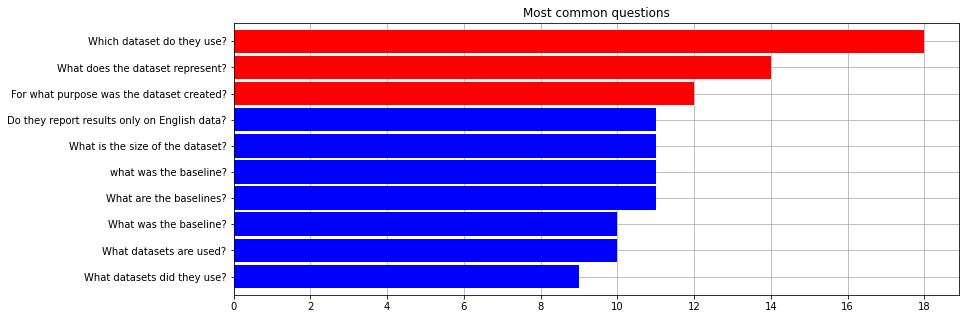

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5))
ax.title.set_text("Most common questions")
df_filtered["question"].value_counts().head(10)[-1::-1].plot.barh(width=0.9, color=["blue", "blue", "blue", "blue", "blue",
                                                                                    "blue", "blue", "red", "red", "red"])
ax.grid()
ax.set_axisbelow(True)
ax.set_xticks(np.arange(0, 19, 2))
plt.show()

In [ ]:
df_filtered["question"].value_counts()[-1::-1]

why do they think sentiment features do not result in improvement?     1
What baseline is used for the experimental setup?                      1
What baseline function is used in REINFORCE algorithm?                 1
What baseline do they compare against?                                 1
What baseline did they use?                                            1
                                                                      ..
What is the size of the dataset?                                      11
Do they report results only on English data?                          11
For what purpose was the dataset created?                             12
What does the dataset represent?                                      14
Which dataset do they use?                                            18
Name: question, Length: 980, dtype: int64

In [ ]:
df_filtered

,question,narrowed_context,start-end,answer
0,Are answers in this dataset guaranteed to be s...,This paper describes our submission to the 201...,"[(-1, -1)]",[]
1,"Are reddit and twitter datasets, which are fai...",Real world data differs radically from the ben...,"[(-1, -1)]",[]
2,"Are there elements, other than pitch, that can...",Singing voice conversion is to convert a singe...,"[(-1, -1)]",[]
3,"Based on this paper, what is the more predicti...",hat are considered trustworthy by independent ...,"[(4000, 4045)]","[words embeddings, style, and morality features]"
4,By how much did the results improve?,The rise of social media is enabling people to...,"[(-1, -1)]",[]
...,...,...,...,...
1286,which non-english language was the had the wor...,Sentiment analysis is a widely studied NLP tas...,"[(795, 801)]",[Turkish]
1287,which public datasets were used?,INLINEFORM8 ( INLINEFORM9 ) can be rewritten a...,"[(4000, 4008), (4021, 4039), (4045, 4071), (46...","[CMRC-2017, People's Daily (PD), Children Fair..."
1288,which social media platforms was the data coll...,as following manner. Section SECREF2 describes...,"[(4000, 4006)]",[Twitter]
1289,who annotated the new dataset?,nvestigating the shortcomings of previously re...,"[(4000, 4017), (4752, 4834), (4949, 5047)]","[automatic labeling, lemmatization of the abst..."


In [ ]:
len(df_filtered["question"].value_counts())

980

In [ ]:
X = df_filtered[['question', 'narrowed_context']]
y = df_filtered[["start-end", "answer"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

df_train = pd.concat([X_train, y_train], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
def tokenize_df(df, tokenizer, MAX_LEN, stride):

    return tokenizer(
        list(df['question']),
        list(df['narrowed_context']),
        max_length = MAX_LEN,
        return_overflowing_tokens = True,
        truncation = 'only_second',
        return_offsets_mapping = True,
        stride = stride,
        padding = 'max_length'
    )


In [ ]:
def preprocess_data(df, tokenizer, max_len, stride):
    start_positions = []
    end_positions = []

    tokenized = tokenize_df(df, tokenizer, max_len, stride)

    offsets_mapping = tokenized["offset_mapping"]
    for i, offset in enumerate(offsets_mapping):
        sequence_ids = tokenized.token_type_ids[i]
        
        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 2

        df_index = tokenized["overflow_to_sample_mapping"][i]
        list_start_end = df.loc[df_index, "start-end"]
        if i == 774:
          print(list_start_end, context_start, context_end, df_index, offset[context_start][0], offset[context_end][1])

        for start_char, end_char in list_start_end:
            if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
                continue
            elif offset[context_start][0] > start_char:
                continue
            else:
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)
                if i == 2:
                    print(start_positions, end_positions)
                break
        
        if len(start_positions) == i:
            start_positions.append(0)
            end_positions.append(0)
    
        if i == 774:
            print(start_positions, end_positions)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    
    return tokenized

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("deepakvk/xlnet-base-cased-squad2")

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 512
stride = 128

data_preprocessing_pipeline = lambda df: preprocess_data(df, tokenizer, MAX_LEN, stride)

df_train_tokenized = data_preprocessing_pipeline(df_train)
df_val_tokenized = data_preprocessing_pipeline(df_val)
df_test_tokenized = data_preprocessing_pipeline(df_test)

[0, 0, 319] [0, 0, 329]
[(4000, 4013)] 8 509 121 0 2138
[0, 0, 319, 0, 0, 115, 0, 0, 0, 204, 0, 0, 0, 0, 509, 135, 0, 0, 0, 0, 0, 0, 324, 40, 0, 0, 0, 0, 0, 0, 0, 0, 436, 61, 0, 0, 423, 59, 0, 0, 0, 0, 0, 489, 116, 0, 0, 0, 232, 0, 0, 0, 491, 120, 0, 0, 0, 0, 288, 0, 0, 498, 124, 0, 0, 0, 171, 0, 0, 0, 457, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 407, 38, 0, 0, 0, 429, 59, 0, 0, 266, 0, 0, 122, 0, 0, 0, 0, 0, 308, 41, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 151, 0, 0, 0, 464, 90, 0, 0, 0, 359, 0, 0, 0, 476, 215, 0, 0, 0, 0, 179, 0, 0, 0, 335, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 165, 0, 0, 0, 0, 337, 0, 0, 0, 0, 439, 65, 0, 0, 0, 499, 125, 0, 353, 0, 184, 35, 0, 0, 0, 0, 485, 111, 0, 0, 0, 0, 209, 0, 0, 0, 0, 482, 110, 0, 0, 0, 0, 347, 0, 0, 0, 0, 198, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 223, 0, 0, 0, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 0, 0, 0, 0, 472, 98, 0, 0, 0, 0, 312, 20, 0, 0, 0, 0, 286, 14, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 137, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 0,

In [ ]:
class TextDataset(Dataset):
  def __init__(self, questions, starts, ends, attention_masks, df_index, offset_mapping):
    self.questions = questions
    self.starts = starts
    self.ends = ends
    self.attention_masks = attention_masks
    self.df_index = df_index
    self.offset_mapping = offset_mapping

  def __len__(self):
    return len(self.questions)

  def __getitem__(self, item):
    question = self.questions[item]
    attention_mask = self.attention_masks[item]
    start = self.starts[item]
    end = self.ends[item]
    df_index = self.df_index[item]
    offset_mapping = self.offset_mapping[item]


    return {
      'input_ids': torch.tensor(question, dtype = torch.long),
      'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
      'start_positions': torch.tensor(start, dtype=torch.long),
      'end_positions' : torch.tensor(end, dtype = torch.long),
      'df_index': torch.tensor(df_index, dtype=torch.long),
      'offset_mapping': offset_mapping
    }

In [ ]:
train_dataset = TextDataset(
    questions = df_train_tokenized['input_ids'],
    starts = df_train_tokenized['start_positions'],
    ends = df_train_tokenized['end_positions'],
    attention_masks = df_train_tokenized['attention_mask'],
    df_index = df_train_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_train_tokenized["offset_mapping"]
)

val_dataset = TextDataset(
    questions = df_val_tokenized['input_ids'],
    starts = df_val_tokenized['start_positions'],
    ends = df_val_tokenized['end_positions'],
    attention_masks = df_val_tokenized['attention_mask'],
    df_index = df_val_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_val_tokenized["offset_mapping"]
)

test_dataset = TextDataset(
    questions = df_test_tokenized['input_ids'],
    starts = df_test_tokenized['start_positions'],
    ends = df_test_tokenized['end_positions'],
    attention_masks = df_test_tokenized['attention_mask'],
    df_index = df_test_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_test_tokenized["offset_mapping"]
)

In [ ]:
batch_size = 8


# train_sampler = RandomSampler(train_data)
# val_sampler = RandomSampler(val_data)
# test_sampler = RandomSampler(test_data)

# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
# val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)
# test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [ ]:
import gc
gc.collect()
import torch
torch.cuda.empty_cache()
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda")

In [ ]:
from transformers import TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("deepakvk/xlnet-base-cased-squad2").to(device)
model_checkpoint = "deepakvk/xlnet-base-cased-squad2"

model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir = "/content/drive/MyDrive/SEW.NLP/logs/xlnet_7",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    logging_dir = "./logs/runs",
    do_train = True,
    do_eval = True,
    learning_rate=5e-5, # best 5e-5
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=6, # best 6
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps = 25

)

Downloading:   0%|          | 0.00/945 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator


trainer = Trainer(
    model,
    args,
    train_dataset= train_dataset,
    eval_dataset= val_dataset,
    data_collator=data_collator
)

In [ ]:
%%time
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6281
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 8
  Total optimization steps = 294
The following columns in the training set don't have a corresponding argument in `XLNetForQuestionAnsweringSimple.forward` and have been ignored: offset_mapping, df_index. If offset_mapping, df_index are not expected by `XLNetForQuestionAnsweringSimple.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss
0,1.333200,1.099816
1,0.913500,1.070145
2,0.669200,1.206309


***** Running Evaluation *****
  Num examples = 777
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `XLNetForQuestionAnsweringSimple.forward` and have been ignored: offset_mapping, df_index. If offset_mapping, df_index are not expected by `XLNetForQuestionAnsweringSimple.forward`,  you can safely ignore this message.
Saving model checkpoint to /content/drive/MyDrive/SEW.NLP/logs/xlnet_7/checkpoint-98
Configuration saved in /content/drive/MyDrive/SEW.NLP/logs/xlnet_7/checkpoint-98/config.json
Model weights saved in /content/drive/MyDrive/SEW.NLP/logs/xlnet_7/checkpoint-98/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 777
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `XLNetForQuestionAnsweringSimple.forward` and have been ignored: offset_mapping, df_index. If offset_mapping, df_index are not expected by `XLNetForQuestionAnsweringSimple.forward`,  you can safely ig

CPU times: user 26min 56s, sys: 3min 35s, total: 30min 32s
Wall time: 29min 43s


TrainOutput(global_step=294, training_loss=1.1638301635275081, metrics={'train_runtime': 1783.1615, 'train_samples_per_second': 10.567, 'train_steps_per_second': 0.165, 'total_flos': 5331264684797952.0, 'train_loss': 1.1638301635275081, 'epoch': 3.0})

In [ ]:
# current best "/content/drive/MyDrive/SEW.NLP/logs/xlnet_6/checkpoint-262"

PATH_MODEL = "/content/drive/MyDrive/SEW.NLP/logs/xlnet_6/checkpoint-262" # path of model saved at best epoch

In [ ]:
best_model = AutoModelForQuestionAnswering.from_pretrained(PATH_MODEL)

In [ ]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

val_predictions = best_trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 777
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `XLNetForQuestionAnsweringSimple.forward` and have been ignored: offset_mapping, df_index. If offset_mapping, df_index are not expected by `XLNetForQuestionAnsweringSimple.forward`,  you can safely ignore this message.


In [ ]:
df_train_tokenized[0].tokens

In [ ]:
def compute_best_prediction(start_indexes, end_indexes,
                            start_logits, end_logits,
                            sequence_ids, offset_mapping, context):
    """
      Computes best feasible prediction and compares it with null prediction
    """


    best_score, null_score = -np.inf, -np.inf
    best_answer = ""
    best_start, best_end = 0, 0

    
    for start_index in start_indexes:
        for end_index in end_indexes:
            score = start_logits[start_index] + end_logits[end_index]
            if start_index == 0 or end_index == 0: # null prediction
                if start_index != end_index:
                    continue
                null_score = score
            
            elif start_index <= end_index and sequence_ids[start_index] == 1 and sequence_ids[end_index] == 1 and start_index != 510 and end_index != 510:
                if score > best_score:
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    if end_char > 0:
                        best_answer = context[start_char:end_char]
                        best_score = score
                        best_start = start_index
                        best_end = end_index
    
    score_diff = null_score - best_score
    

    return {
        "score_diff": score_diff,
        "pred_start": best_start,
        "pred_end": best_end,
        "pred_answer": best_answer
    }

In [ ]:
def get_preds_df(predictions, df, tokenized_df, dataset):
    predicted_answers = []
    n_best_size = 20

    test_start_logits, test_end_logits = predictions.predictions
    start_labels, end_labels = tokenized_df["start_positions"], tokenized_df["end_positions"]

    for i in range(len(dataset)):

        start_label, end_label = start_labels[i], end_labels[i]
        start_logits, end_logits = test_start_logits[i], test_end_logits[i]

        start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
        end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

        row_idx = dataset[i]["df_index"].item()
        row_context = df.loc[row_idx, "narrowed_context"]
        offset_mapping = dataset[i]["offset_mapping"]
        sequence_ids = tokenized_df.token_type_ids[i]
        
        # find predicted answer:
        prediction = compute_best_prediction(start_indexes, end_indexes, start_logits, end_logits, sequence_ids, offset_mapping, row_context)
        
        # find correct answer:
        start_char_true = offset_mapping[start_label][0]
        end_char_true = offset_mapping[end_label][1]
        correct_answer = row_context[start_char_true:end_char_true+1] if end_label > 0 else ""
        
        prediction["pred_token"] = tokenized_df[i].tokens[prediction["pred_start"]:prediction["pred_end"]+1]
        prediction["start_label"] = start_label
        prediction["end_label"] = end_label
        prediction["correct_answer"] = correct_answer
        prediction["correct_token"] = tokenized_df[i].tokens[start_label:end_label+1] if end_label > 0 else ["<cls>"]

        predicted_answers.append(prediction)

    preds_df = pd.DataFrame(predicted_answers)
    preds_df["NoAnsw"] = preds_df.apply(lambda row: row["correct_token"] == ["<cls>"], axis=1)
    
    return preds_df

In [ ]:
val_preds_df = get_preds_df(val_predictions, df_val, df_val_tokenized, val_dataset)

In [ ]:
val_preds_df[val_preds_df["correct_answer"] != ""].tail(50)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
549,-1.885360,218,232,"R, RMSE, MSE, bias, and computational time com...","[▁R, ,, ▁, RM, SE, ,, ▁M, SE, ,, ▁bias, ,, ▁an...",208,235,we evaluated its performance on the testing da...,"[▁we, ▁evaluated, ▁its, ▁performance, ▁on, ▁th...",False
553,-3.145474,245,277,"bag-of-words (BOW), term frequency–inverse doc...","[▁bag, -, of, -, word, s, ▁, (, BO, W, ), ,, ▁...",245,255,"bag-of-words (BOW),","[▁bag, -, of, -, word, s, ▁, (, BO, W, )]",False
556,-2.815018,180,183,Meta-LSTM,"[▁Meta, -, LS, TM]",178,187,) the Meta-LSTM BIBREF0,"[), ▁the, ▁Meta, -, LS, TM, ▁, BI, BR, EF]",False
563,-6.857100,274,283,Daily Mail news articles released by BIBREF,"[▁Daily, ▁Mail, ▁news, ▁articles, ▁released, ▁...",274,284,Daily Mail news articles released by BIBREF9,"[▁Daily, ▁Mail, ▁news, ▁articles, ▁released, ▁...",False
569,2.232587,339,367,three of the large-scale document classificati...,"[▁three, ▁of, ▁the, ▁large, -, scale, ▁documen...",342,355,large-scale document classification datasets i...,"[▁large, -, scale, ▁document, ▁classification,...",False
580,-2.373489,427,435,Stanford Sentiment Treebank movie reviews dataset,"[▁Stanford, ▁Sen, ti, ment, ▁Tree, bank, ▁movi...",427,432,Stanford Sentiment Treebank,"[▁Stanford, ▁Sen, ti, ment, ▁Tree, bank]",False
581,-2.002007,54,62,Stanford Sentiment Treebank movie reviews dataset,"[▁Stanford, ▁Sen, ti, ment, ▁Tree, bank, ▁movi...",54,59,Stanford Sentiment Treebank,"[▁Stanford, ▁Sen, ti, ment, ▁Tree, bank]",False
586,-1.429255,148,149,BLEU,"[BL, EU]",148,149,BLEU,"[BL, EU]",False
591,0.754134,266,273,$n$-gram based similarity metric,"[▁$, n, $, -, gram, ▁based, ▁similarity, ▁metric]",501,504,"Self-BLEU,","[▁Self, -, BL, EU]",False
592,0.171875,363,367,n-gram based score,"[n, -, gram, ▁based, ▁score]",127,130,"Self-BLEU,","[▁Self, -, BL, EU]",False


In [ ]:
import collections

def compute_f1(gold_toks, pred_toks):
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [ ]:
def get_f1_df(preds_df):
    f1_data = {"threshold": [], "f1":[], "f1_Answ":[], "f1_NoAnsw":[]}

    for threshold in np.arange(-3, 10, 1):
        temp = preds_df.copy()
        temp["pred_token"] = temp.apply(lambda row: row["pred_token"] if row["score_diff"] < threshold else ["<cls>"], axis=1)
        temp["f1"] = temp.apply(lambda r: compute_f1(r["correct_token"], r["pred_token"]), axis=1)

        f1_total = 100 * np.mean(temp["f1"])
        f1_scores = list(100 * temp.groupby("NoAnsw").agg(["mean"])["f1"]["mean"])
        
        f1_data["threshold"].append(threshold)
        f1_data["f1"].append(f1_total)
        f1_data["f1_Answ"].append(f1_scores[0])
        f1_data["f1_NoAnsw"].append(f1_scores[1])

    df_scores = pd.DataFrame(f1_data)

    return df_scores
val_scores = get_f1_df(val_preds_df)

In [ ]:
val_scores

,threshold,f1,f1_Answ,f1_NoAnsw
0,-3,79.146385,18.403899,98.807496
1,-2,79.966091,24.387647,97.955707
2,-1,79.942347,27.448440,96.933560
3,0,78.859817,30.389885,94.548552
4,1,78.526388,35.868437,92.333901
5,2,76.585969,38.459463,88.926746
6,3,73.493647,40.550337,84.156729
7,4,70.926550,42.683839,80.068143
8,5,66.940962,43.753301,74.446337
9,6,63.291302,44.617586,69.335605


In [ ]:
val_scores.to_csv("/content/drive/MyDrive/SEW.NLP/Edoardo B 48 LR 5e-5_val_scores_xlnet_.csv")

In [ ]:
val_scores = pd.read_csv("/content/drive/MyDrive/SEW.NLP/Edoardo B 48 LR 5e-5_val_scores_xlnet_.csv", index_col=0)

In [ ]:
val_scores

,threshold,f1,f1_Answ,f1_NoAnsw
0,-3,79.146385,18.403899,98.807496
1,-2,79.966091,24.387647,97.955707
2,-1,79.942347,27.448440,96.933560
3,0,78.859817,30.389885,94.548552
4,1,78.526388,35.868437,92.333901
5,2,76.585969,38.459463,88.926746
6,3,73.493647,40.550337,84.156729
7,4,70.926550,42.683839,80.068143
8,5,66.940962,43.753301,74.446337
9,6,63.291302,44.617586,69.335605


In [ ]:
val_scores

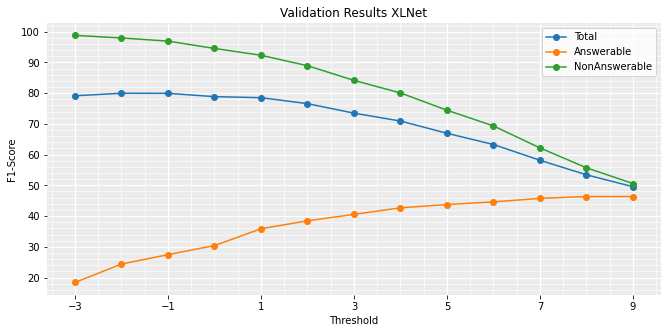

In [ ]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))
ax.title.set_text("Validation Results XLNet")

ax.set_facecolor('#EBEBEB')
# Remove border around plot.
[ax.spines[side].set_visible(False) for side in ax.spines]
# Style the grid.
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)
# Show the minor ticks and grid.
ax.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
ax.tick_params(which='minor', bottom=False, left=False)


ax.plot(val_scores["threshold"], val_scores["f1"], "-o", label="Total")
ax.plot(val_scores["threshold"], val_scores["f1_Answ"], "-o", label="Answerable")
ax.plot(val_scores["threshold"], val_scores["f1_NoAnsw"], "-o", label="NonAnswerable")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1-Score")
ax.set_xticks(np.array(val_scores["threshold"])[::2])
ax.legend()
plt.show()

In [ ]:
## Pick a threshold with decent f1 and good f1_Answ, like 3 or 4
threshold = 3

In [ ]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

test_predictions = best_trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 823
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `XLNetForQuestionAnsweringSimple.forward` and have been ignored: offset_mapping, df_index. If offset_mapping, df_index are not expected by `XLNetForQuestionAnsweringSimple.forward`,  you can safely ignore this message.


In [ ]:
test_preds_df = get_preds_df(test_predictions, df_test, df_test_tokenized, test_dataset)

In [ ]:
test_preds_df[test_preds_df["correct_answer"] != ""].head(50)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
2,3.288438,100,111,ATIS (Airline Travel Information Systems) dataset,"[▁AT, I, S, ▁, (, Air, line, ▁Travel, ▁Informa...",248,251,ROMULUS dataset.,"[ROM, UL, US, ▁dataset]",False
5,2.774209,178,186,#LokSabhaElections2019,"[#, Lo, k, Sa, bha, Elect, ions, 20, 19]",25,25,"username,",[▁username],False
11,0.690770,177,192,Active Users of set $\mathbf {S}$,"[Activ, e, ▁Users, ▁of, ▁set, ▁$, \, ma, th, b...",398,408,"username, display name, profile image, locatio...","[▁username, ,, ▁display, ▁name, ,, ▁profile, ▁...",False
12,5.162405,26,36,"username, display name, profile image, locatio...","[▁username, ,, ▁display, ▁name, ,, ▁profile, ▁...",26,36,"username, display name, profile image, locatio...","[▁username, ,, ▁display, ▁name, ,, ▁profile, ▁...",False
16,1.455661,239,252,To address the need for a large and high-quali...,"[▁To, ▁address, ▁the, ▁need, ▁for, ▁a, ▁large,...",239,252,To address the need for a large and high-quali...,"[▁To, ▁address, ▁the, ▁need, ▁for, ▁a, ▁large,...",False
20,1.479667,260,262,SQuAD,"[S, Qu, AD]",325,328,BIBREF14,"[BI, BR, EF, 14]",False
21,6.297492,38,38,MT,[MT],367,372,pre-trained multi-BERT,"[▁pre, -, trained, ▁multi, -, BER]",False
22,6.848415,313,316,multi-BERT,"[▁multi, -, BER, T]",454,456,QANet,"[▁Q, A, Net]",False
23,1.881864,150,151,BERT,"[▁B, ERT]",81,83,QANet,"[▁Q, A, Net]",False
26,6.533589,426,431,"Cora, arXiv","[▁Cora, ,, ▁, ar, X, iv]",426,426,"Cora,",[▁Cora],False


In [ ]:
df_test[:50]

,question,narrowed_context,start-end,answer
0,Which publicly available NLU dataset is used?,"e act and multi-intent. In fact, it is possibl...","[(4000, 4014)]",[ROMULUS dataset]
1,What profile metadata is used for this analysis?,Users on Twitter are identified with the help ...,"[(91, 98), (101, 112), (115, 127), (1661, 1668...","[username, display name, profile image, locati..."
2,For what purpose was the dataset collected?,We present the Stanford Question Answering Dat...,"[(2595, 2672)]",[To address the need for a large and high-qual...
3,What model is used as a baseline?,Because it is not feasible to collect training...,"[(3123, 3144), (5195, 5200), (1306, 1313), (54...","[pre-trained multi-BERT, QANet, BIBREF14, fine..."
4,Which dataset of texts do they use?,Constituting highly informative network embedd...,"[(1982, 1985), (15358, 15362), (15490, 15494)]","[Cora, Hepth, Zhihu]"
5,What datasets are used?,ifferent representation modalities are thought...,"[(4000, 4020)]",[the ERP data: BIBREF0]
6,What is the size of the dataset?,zation approaches and obtained encouraging res...,"[(4000, 4002)]",[20K]
7,Which datasets do they use?,"ms of the features used for ranking, we classi...","[(18723, 18732), (18872, 18878), (18998, 19004...","[CoNLL-YAGO, TAC2010, ACE2004, AQUAINT, WW]"
8,What hand-crafted features are used?,In comparison with document summarization on t...,"[(5210, 5229), (5232, 5246), (5252, 5256), (53...","[position of sentence, sentence length, tense,..."
9,What public online harassment datasets was the...,covered that ParityBOT played a role in changi...,"[(4000, 4104), (4014, 4104)]","[20194 cleaned, unique tweets identified as ei..."


In [ ]:
test_scores = get_f1_df(test_preds_df)

In [ ]:
test_scores[test_scores["threshold"] == threshold] # final score

,threshold,f1,f1_Answ,f1_NoAnsw
6,3,71.161741,37.067771,83.833333


In [ ]:
# Ensemble

In [ ]:
best_scibert = AutoModelForQuestionAnswering.from_pretrained("/content/drive/MyDrive/SEW.NLP/logs/scibert-squad_24/checkpoint-177")

loading configuration file /content/drive/MyDrive/SEW.NLP/logs/scibert-squad_24/checkpoint-177/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/SEW.NLP/logs/scibert-squad_24/checkpoint-177",
  "_num_labels": 2,
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading weights file /content/drive/MyDrive/SEW.NLP/logs/scibert-squad_24/checkpoint-177/pytorch_model.bin
All model checkpoint weights w

In [ ]:
scibert_trainer = Trainer(
    best_scibert,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

val_scibert_predictions = scibert_trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 777
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, df_index. If offset_mapping, df_index are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.


RuntimeError: ignored